<a href="https://colab.research.google.com/github/sharanv16/AI-Game/blob/main/Copy_AI_Proj1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Forming the Grid

create a closed square grid

*   0 implies open cell
*   -1 implies closed cell
*   1 implies alien
*   10 implies captain
*   2 implies bot


# IMPORTS

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt

# MAKING THE GRID

In [16]:
#Parameters grid size,number of aliens
class Grid:
  def __init__(self,n,no_of_aliens):
    self.no_of_aliens =no_of_aliens
    self.n = n
    self.grid = np.full((self.n,self.n),-1)
    self.rows, self.cols = self.grid.shape
    # assign a random start point
    self.x_start =  random.randint(0,self.n-1)
    self.y_start =  random.randint(0,self.n-1)
    #print(f" start = {self.x_start} {self.y_start}")
    self.grid[self.x_start,self.y_start] = 0
    #start building paths from the start point

  def find_closed_cells_with_one_open_neighbor(self):
    self.results = []
    for i in range(self.rows):
      for j in range(self.cols):
        if self.grid[i, j] == -1:  # Check for closed cells only
          self.adjacent_cells = [(i - 1, j), (i, j - 1), (i + 1, j), (i, j + 1)]
          self.adjacent_cells = [(x, y) for x, y in self.adjacent_cells if 0 <= x < self.rows and 0 <= y < self.cols]
          self.num_zero_neighbors = sum(self.grid[x, y] == 0 for x, y in self.adjacent_cells)
          if self.num_zero_neighbors == 1:
            self.results.append((i, j))
    return self.results


  def create_grid(self):
    self.closed_cells = []
    self.avl_cells = self.find_closed_cells_with_one_open_neighbor()
    #print(self.avl_cells)
    while self.avl_cells:
      p = random.choice(self.avl_cells)
      self.grid[p] = 0
      self.avl_cells = []
      self.avl_cells = self.find_closed_cells_with_one_open_neighbor()
    for i in range(self.rows):
      for j in range(self.cols):
        if self.grid[i,j] ==-1:
          self.closed_cells.append((i,j))
    self.l = len(self.closed_cells)//2
    while self.l:
      random_cell = random.choice(self.closed_cells)
      self.grid[random_cell]  = 0
      self.closed_cells.remove(random_cell)
      self.l-=1



  def find_open_cells(self):
    self.open_cells = []
    for i in range(self.rows):
      for j in range(self.cols):
        if self.grid[i,j] == 0:
          self.open_cells.append((i,j))

  def place_aliens(self):
    k = self.no_of_aliens
    self.find_open_cells()
    self.alien_cells=[]
    while k:
      r = random.choice(self.open_cells)
      self.grid[r] = 1
      self.alien_cells.append(r)
      self.open_cells.remove(r)
      k -=1


  def place_bot(self):
    r =  random.choice(self.open_cells)
    self.grid[r] = 2
    self.start = r

  def place_captain(self):
    r = random.choice(self.open_cells)
    self.grid[r] = 10
    self.goal = r

  def place_players(self):
    self.place_aliens()
    self.place_captain()
    self.place_bot()


  def show_grid(self):
    print(self.grid)



# VISUALIZING THE GRID

In [14]:
def show_color_grid(grid):

  color_map = {
    0: "white",
    -1: "black",
    1: "green",
    10: "red",
    2: "blue",
  }

# Create the figure and axes
  fig, ax = plt.subplots()

# Define cell width and height
  cell_width = 1
  cell_height = 1

# Fill the cells with the "x" pattern
  for i in range(len(grid)):
    for j in range(len(grid[i])):
      color = color_map[grid[i][j]]
      x = j * cell_width
      y = i * cell_height
      ax.plot([x, x + cell_width, x + cell_width, x],
                [y, y + cell_height, y, y + cell_height],
                color=color, linewidth=2)

# Draw black borders around each cell
  for i in range(len(grid)):
    for j in range(len(grid[i])):
      ax.plot([j, j + 1], [i, i], color="black", linewidth=1)
      ax.plot([j, j + 1], [i + 1, i + 1], color="black", linewidth=1)
      ax.plot([j, j], [i, i + 1], color="black", linewidth=1)
      ax.plot([j + 1, j + 1], [i, i + 1], color="black", linewidth=1)

# Set limits and labels
  ax.set_xlim(0, len(grid[0]) * cell_width)
  ax.set_ylim(0, len(grid) * cell_height)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_xlabel("X")
  ax.set_ylabel("Y")

# Turn off axes
  ax.axis('off')

# Show the plot
  plt.show()

# Bot1 Class


In [ ]:
class Bot1:
    def __init__(self, grid, start, goal, alien_cells):
        self.grid = grid.copy()  # Create a copy of the grid
        self.goal = goal
        self.start = start
        self.alien_cells = alien_cells
        self.rows, self.cols = self.grid.shape

    def print_grid(self):
        print(self.grid)  # Print the original grid

    def find_shortest_path(self, grid):  # Accept grid as an argument
        queue = [(self.start, [self.start])]
        visited = set()
        while queue:
            cell, path = queue.pop(0)
            visited.add(cell)

            if cell == self.goal:
                return path

            for neighbor in [(cell[0] + 1, cell[1]), (cell[0] - 1, cell[1]),
                              (cell[0], cell[1] + 1), (cell[0], cell[1] - 1)]:
                if 0 <= neighbor[0] < self.rows and 0 <= neighbor[1] < self.cols and grid[neighbor] != -1 and neighbor not in visited:
                    queue.append((neighbor, path + [neighbor]))

        return None

    def get_adjacent_cells(self, x, y):
        adjacent_cells = []
        if 0 <= x - 1 < self.grid.shape[0]:
            adjacent_cells.append((x - 1, y))  # Top
        if 0 <= y - 1 < self.grid.shape[1]:
            adjacent_cells.append((x, y - 1))  # Left
        if 0 <= x + 1 < self.grid.shape[0]:
            adjacent_cells.append((x + 1, y))  # Bottom
        if 0 <= y + 1 < self.grid.shape[1]:
            adjacent_cells.append((x, y + 1))  # Right
        return adjacent_cells

    def start_rescue(self):
        local_grid = self.grid.copy()  # Create a local copy for pathfinding and movements

        self.path = self.find_shortest_path(local_grid)  # Use local_grid for pathfinding
        prev_cell = [self.start]
        flag = 0
        self.bot_path = [self.start]

        while flag == 0:
            for cell in self.path:
                print("\n \n")
                print(local_grid)  # Print the local grid
                local_grid[cell] = 2  # Update local_grid, not the original
                local_grid[prev_cell] = 0
                prev_cell = cell

                if cell == self.goal:
                    flag = 1
                    break

                chosen_alien = random.choice(self.alien_cells)
                alien_possible_moves = self.get_adjacent_cells(chosen_alien[0], chosen_alien[1])
                random_cell_choice = random.choice(alien_possible_moves)
                print(f"Alien moves from {chosen_alien} to {random_cell_choice}")

                if local_grid[random_cell_choice] == 2:
                    flag = 2
                    break
                else:
                    local_grid[random_cell_choice] = 1
                    local_grid[chosen_alien] = 0
                    self.alien_cells.remove(chosen_alien)
                    self.alien_cells.append(random_cell_choice)
                    self.bot_path.append(cell)

        if flag == 1:
            print("GOAL REACHED")
        else:
            print("GOAL FAILED")
            print(f"Alien met bot at {random_cell_choice}")
        print(self.bot_path)
        print(f"no of steps taken = {len(self.bot_path)}")


# BOT 2

In [ ]:
class Bot2:
    def __init__(self, grid, start, goal, alien_cells):
        self.grid = grid.copy()  # Create a copy of the grid
        self.goal = goal
        self.start = start
        self.alien_cells = alien_cells
        self.rows, self.cols = self.grid.shape

    def print_grid(self):
        print(self.grid)  # Print the original grid

    def find_shortest_path(self, grid):  # Accept grid as an argument
        queue = [(self.start, [self.start])]
        visited = set()

        while queue:
            cell, path = queue.pop(0)
            visited.add(cell)

            if cell == self.goal:
                return path

            for neighbor in [(cell[0] + 1, cell[1]), (cell[0] - 1, cell[1]),
                              (cell[0], cell[1] + 1), (cell[0], cell[1] - 1)]:
                if 0 <= neighbor[0] < self.rows and 0 <= neighbor[1] < self.cols and grid[neighbor] != -1 and grid[neighbor] != 1 and neighbor not in visited:
                    queue.append((neighbor, path + [neighbor]))

        return None

    def get_adjacent_cells(self, x, y):
        adjacent_cells = []
        if 0 <= x - 1 < self.grid.shape[0]:
            adjacent_cells.append((x - 1, y))  # Top
        if 0 <= y - 1 < self.grid.shape[1]:
            adjacent_cells.append((x, y - 1))  # Left
        if 0 <= x + 1 < self.grid.shape[0]:
            adjacent_cells.append((x + 1, y))  # Bottom
        if 0 <= y + 1 < self.grid.shape[1]:
            adjacent_cells.append((x, y + 1))  # Right
        return adjacent_cells

    def start_rescue(self):
        local_grid = self.grid.copy()  # Create a local copy for pathfinding and movements
        self.path = self.find_shortest_path(local_grid)  # Use local_grid for pathfinding
        prev_cell = [self.start]
        flag = 0
        self.bot_path = [self.start]
        self.total_wait = 0

        while flag == 0:
            self.path =self.find_shortest_path(local_grid)
            if self.path is None:
              self.wait_count +=1
              if self.wait_count>100:
                flag = 2
                break
            self.total_wait += self.wait_count
            for cell in self.path:
              self.wait_count = 0
              print("\n \n")
              print(local_grid)  # Print the local grid
              local_grid[cell] = 2  # Update local_grid, not the original
              local_grid[prev_cell] = 0
              prev_cell = cell

              if cell == self.goal:
                  flag = 1
                  break

              chosen_alien = random.choice(self.alien_cells)
              alien_possible_moves = self.get_adjacent_cells(chosen_alien[0], chosen_alien[1])
              random_cell_choice = random.choice(alien_possible_moves)
              print(f"Alien moves from {chosen_alien} to {random_cell_choice}")

              if local_grid[random_cell_choice] == 2:
                  flag = 2
                  break
              else:
                  local_grid[random_cell_choice] = 1
                  local_grid[chosen_alien] = 0
                  self.alien_cells.remove(chosen_alien)
                  self.alien_cells.append(random_cell_choice)
                  self.bot_path.append(cell)

        if flag == 1:
            print("GOAL REACHED")
        elif flag== 2:
          print(local_grid)
          print("Bot is stuck")
          print(f"no.of steps taken = {len(self.bot_path)} + 100 idle steps")
        else:
            print("GOAL FAILED")
            print(f"Alien met bot at {random_cell_choice}")
        print(self.bot_path)
        print(f"no of steps taken = {len(self.bot_path)}")


# BOT 3

In [ ]:
#shortest path treating the adj cells of aliens as closed if no path found treat bot 2 logic
# need a copy of the grid
class BOT3:
  def __init__(self,grid,start,goal,alien_cells):
    self.grid = grid
    self.start = start
    self.goal = goal
    self.alien_cells = alien_cells

  def get_adjacent_cells(self, x, y):
    adjacent_cells = []
      if 0 <= x - 1 < self.grid.shape[0]:
          adjacent_cells.append((x - 1, y))  # Top
      if 0 <= y - 1 < self.grid.shape[1]:
          adjacent_cells.append((x, y - 1))  # Left
      if 0 <= x + 1 < self.grid.shape[0]:
          adjacent_cells.append((x + 1, y))  # Bottom
      if 0 <= y + 1 < self.grid.shape[1]:
          adjacent_cells.append((x, y + 1))  # Right
      return adjacent_cells


  def transform_grid(self):
    for cell in self.aliens:
      self.adj_cells = self.get_adjacent_cells(cell[0],cell[1])
      for adj_cell in self.adj_cells:
        if self.grid1[adj_cell] == 0:
          self.grid1[adj_cell] = 1
    return self.grid1

  def find_shortest_path(self, grid):  # Accept grid as an argument
    queue = [(self.start, [self.start])]
    visited = set()

    while queue:
        cell, path = queue.pop(0)
        visited.add(cell)

        if cell == self.goal:
            return path

        for neighbor in [(cell[0] + 1, cell[1]), (cell[0] - 1, cell[1]),
                              (cell[0], cell[1] + 1), (cell[0], cell[1] - 1)]:
                              if 0 <= neighbor[0] < self.rows and 0 <= neighbor[1] < self.cols and grid[neighbor] != -1 and grid[neighbor] != 1 and neighbor not in visited:
                    queue.append((neighbor, path + [neighbor]))

        return None

  def start_rescue(self):
    self.grid1 =self.transform_grid(self.grid.copy())
    self.path = self.find_shortest_path(self,self.grid1):
    if self.path is None:
      self.path = self.find_shortest_path(self.grid)
    flag = 0
    self.total_wait = 0

    while flag == 0:
      if self.path is None:
        self.wait_count+=1
        if self.wait_count>100:
          flag =1
          break
      self.total_wait += self.wait_count






















# MAIN

In [17]:
g = Grid(10,5)
g.create_grid()
g.place_players()
#g.show_grid()
#print(f" start = {g.start} \n goal = {g.goal}")

In [18]:
g.show_grid()
g.start

[[ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 -1  0 -1]
 [-1 -1  1 -1 -1 -1  0  1 -1  0]
 [ 0  0  0  0  1  0  0  1  0  0]
 [ 0  0 -1  1  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 -1  0  0  0  0  0]
 [ 0 -1  0  0 -1  0  0  0 -1  0]
 [ 0  0  0  0  0  0 -1  0  0 -1]
 [-1  0  0  0  0  2  0  0  0  0]]


(9, 5)

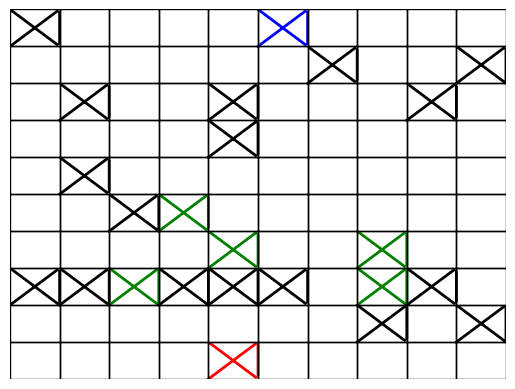

In [19]:
show_color_grid(g.grid)

In [ ]:
b1 = Bot1(g.grid.copy(),g.start,g.goal,g.alien_cells)
b1.start_rescue()


 

[[ 0 -1  0  0  0  0  0 -1  0  0]
 [ 0 -1  0 -1  0 -1  0 -1  1 -1]
 [ 0  0  0 -1 -1  0  0 -1  0  0]
 [ 0 -1  0  0 10 -1 -1  0 -1  0]
 [-1  0  0 -1  0  0 -1  0 -1  1]
 [ 0 -1  0 -1 -1  0  0  0  0  0]
 [ 0 -1  0  0  0 -1  0 -1 -1  1]
 [ 0  0  0 -1  0  0 -1  2  0  0]
 [-1  0 -1  0  0 -1  0 -1  0 -1]
 [ 0  0  0 -1  1  0  0 -1  0  1]]
Alien moves from (1, 8) to (1, 9)

 

[[ 0 -1  0  0  0  0  0 -1  0  0]
 [ 0 -1  0 -1  0 -1  0 -1  0  1]
 [ 0  0  0 -1 -1  0  0 -1  0  0]
 [ 0 -1  0  0 10 -1 -1  0 -1  0]
 [-1  0  0 -1  0  0 -1  0 -1  1]
 [ 0 -1  0 -1 -1  0  0  0  0  0]
 [ 0 -1  0  0  0 -1  0 -1 -1  1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [-1  0 -1  0  0 -1  0 -1  0 -1]
 [ 0  0  0 -1  1  0  0 -1  0  1]]
Alien moves from (9, 9) to (9, 8)

 

[[ 0 -1  0  0  0  0  0 -1  0  0]
 [ 0 -1  0 -1  0 -1  0 -1  0  1]
 [ 0  0  0 -1 -1  0  0 -1  0  0]
 [ 0 -1  0  0 10 -1 -1  0 -1  0]
 [-1  0  0 -1  0  0 -1  0 -1  1]
 [ 0 -1  0 -1 -1  0  0  0  0  0]
 [ 0 -1  0  0  0 -1  0 -1 -1  1]
 [ 0  0  0  0  0  0  0  0  

In [ ]:
print(f"distance = {np.sqrt((g.start[0] - g.goal[0])**2 + (g.start[1]-g.goal[1])**2)}")

distance = 5.0


In [ ]:
b2 = Bot2(g.grid.copy(),g.start,g.goal,g.alien_cells)
print(f"start = {g.start} goal = {g.goal}")
g.show_grid()

start = (7, 7) goal = (3, 4)
[[ 0 -1  0  0  0  0  0 -1  0  0]
 [ 0 -1  0 -1  0 -1  0 -1  1 -1]
 [ 0  0  0 -1 -1  0  0 -1  0  0]
 [ 0 -1  0  0 10 -1 -1  0 -1  0]
 [-1  0  0 -1  0  0 -1  0 -1  1]
 [ 0 -1  0 -1 -1  0  0  0  0  0]
 [ 0 -1  0  0  0 -1  0 -1 -1  1]
 [ 0  0  0 -1  0  0 -1  2  0  0]
 [-1  0 -1  0  0 -1  0 -1  0 -1]
 [ 0  0  0 -1  1  0  0 -1  0  1]]


In [ ]:
b2.start_rescue()
b2.path

[[ 0 -1  0  0  0  0  0 -1  0  0]
 [ 0 -1  0 -1  0 -1  0 -1  1 -1]
 [ 0  0  0 -1 -1  0  0 -1  0  0]
 [ 0 -1  0  0 10 -1 -1  0 -1  0]
 [-1  0  0 -1  0  0 -1  0 -1  1]
 [ 0 -1  0 -1 -1  0  0  0  0  0]
 [ 0 -1  0  0  0 -1  0 -1 -1  1]
 [ 0  0  0 -1  0  0 -1  2  0  0]
 [-1  0 -1  0  0 -1  0 -1  0 -1]
 [ 0  0  0 -1  1  0  0 -1  0  1]]
Bot is stuck
no.of steps taken = 1 + 100 idle steps
[(7, 7)]
no of steps taken = 1


In [ ]:
# everything works from here till bot 1 implementation